# Imports

In [157]:
import datetime as dt

import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold

from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
import sys
import os

project_root = os.path.abspath("..")   # one level up from notebooks/
sys.path.append(project_root)

from models.custom_regression_tree import CustomRegressionTree

# Global variables

In [3]:
DATA_PATH = "../data"

RANDOM_STATE = 42

LABEL_COL = "Paddy yield(in Kg)"

# Functions

In [119]:
def get_scores(reals: np.array, preds: np.array) -> dict:
    rmse = np.sqrt(np.mean((preds - reals)**2))
    mape = np.mean(np.abs((reals - preds) / reals)) * 100

    return {"RMSE": rmse, "MAPE": mape}

def generate_cv_summary(model_scores: dict, metric: str = "RMSE") -> None:
    num_models = len(model_scores.keys())
    fig, ax = plt.subplots(1, num_models, figsize=(35,5))
    if num_models == 1:
        ax = [ax]

    min_metric, max_metric = None, None

    all_metrics = [metric_val for model in model_scores.values() for metric_val in model[metric]]
    min_metric, max_metric = np.min(all_metrics), np.max(all_metrics)

    summaries = []
    
    for i, items in enumerate(model_scores.items()):
        k, v = items

        sns.boxplot(v[metric], ax=ax[i])
        ax[i].set_ylim(min_metric*0.9, max_metric*1.1)
        ax[i].set_xlabel(k.replace("@", "\n"))
        ax[i].axhline(((max_metric-min_metric)/2)+min_metric, linestyle="--", c="red")

        summary = {"MODEL": k, "METRIC": metric, "MEAN": np.mean(v[metric]), "MIN": np.min(v[metric]), "MAX": np.max(v[metric]), "STD_DEV": np.std(v[metric])}
        summaries.append(summary)
    df_summary = pd.DataFrame(summaries)
    display(df_summary)
    
    fig.suptitle("Cross-validation for model parameters", fontsize=16)
    plt.tight_layout()

    return df_summary

def generate_cv_summary_v2(model_scores: dict, metric: str = "RMSE") -> None:
    num_models = len(model_scores.keys())
    plt.figure(figsize(30, 5))

    min_metric, max_metric = None, None

    all_metrics = [metric_val for model in model_scores.values() for metric_val in model[metric]]
    min_metric, max_metric = np.min(all_metrics), np.max(all_metrics)

    summaries = []
    
    for i, items in enumerate(model_scores.items()):
        k, v = items

        sns.boxplot(v[metric], ax=ax[i])
        ax[i].set_ylim(min_metric*0.9, max_metric*1.1)
        ax[i].set_xlabel(k.replace("@", "\n"))
        ax[i].axhline(((max_metric-min_metric)/2)+min_metric, linestyle="--", c="red")

        summary = {"MODEL": k, "METRIC": metric, "MEAN": np.mean(v[metric]), "MIN": np.min(v[metric]), "MAX": np.max(v[metric]), "STD_DEV": np.std(v[metric])}
        summaries.append(summary)
    df_summary = pd.DataFrame(summaries)
    display(df_summary)

    sns.boxplot(v[metric],)
    
    fig.suptitle("Cross-validation for model parameters", fontsize=16)
    plt.tight_layout()

    return df_summary

def create_model_name(model: str, params: dict) -> str:
    model_name = model + "@" + str(params).replace(":", "=").replace(" ", "").replace("'", "")
    return model_name

# Data ingestion

In [255]:
df_paddies = pd.read_csv(f"{DATA_PATH}/RicePaddy/paddydataset.csv")
df_paddies

df_paddies = df_paddies.drop("Trash(in bundles)", axis=1)

<Axes: ylabel='Paddy yield(in Kg)'>

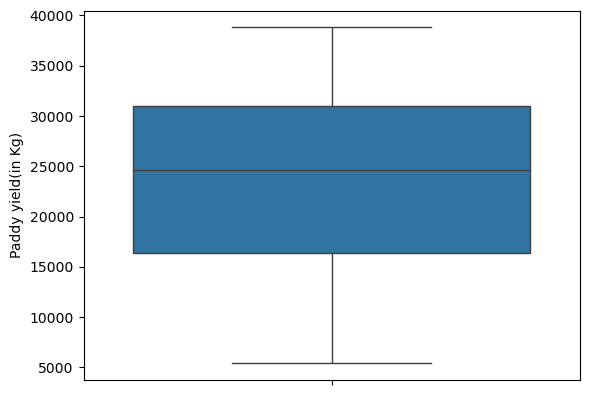

In [256]:
sns.boxplot(df_paddies[LABEL_COL])

# Modeling

## Train-test(holdout) split

In [257]:
df_train, df_test = train_test_split(df_paddies, train_size=0.7, shuffle=True, random_state=RANDOM_STATE)
df_train.shape, df_test.shape

((1952, 44), (837, 44))

## Cross-validation

In [258]:
cust_reg_tree_param_grid = [
    {"max_depth":3, "min_samples_split":2},
    {"max_depth":4, "min_samples_split":2},
    {"max_depth":8, "min_samples_split":2},
    {"max_depth":16, "min_samples_split":2},
    {"max_depth":32, "min_samples_split":2},
    {"max_depth":64, "min_samples_split":2},

    {"max_depth":3, "min_samples_split":4},
    {"max_depth":4, "min_samples_split":4},
    {"max_depth":8, "min_samples_split":4},
    {"max_depth":16, "min_samples_split":4},
    {"max_depth":32, "min_samples_split":4},
    {"max_depth":64, "min_samples_split":4},
]

sklearn_tree_reg_param_grid = [
    {"max_depth":3, "min_samples_split":2},
    {"max_depth":4, "min_samples_split":2},
    {"max_depth":8, "min_samples_split":2},
    {"max_depth":16, "min_samples_split":2},
    {"max_depth":32, "min_samples_split":2},
    {"max_depth":64, "min_samples_split":2},

    {"max_depth":3, "min_samples_split":4},
    {"max_depth":4, "min_samples_split":4},
    {"max_depth":8, "min_samples_split":4},
    {"max_depth":16, "min_samples_split":4},
    {"max_depth":32, "min_samples_split":4},
    {"max_depth":64, "min_samples_split":4},
]

sklearn_linear_reg_param_grid = [
    {"alpha": float(np.round(a, 1)), "max_iter": 2000} for a in np.arange(0.1, 1.0, 0.1)
]

In [259]:
kf = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

feat_cols = [col for col in df_train if col != LABEL_COL]

numeric_features = df_train[feat_cols].select_dtypes(include=["number"]).columns.tolist()
categorical_features = [c for c in feat_cols if c not in numeric_features]

model_scores = {}

# TO DO: Implement time logging
time_performances = {}

for train_idx, validation_idx in kf.split(df_train):
    X_train_raw = df_train.iloc[train_idx][feat_cols]
    X_validation_raw  = df_train.iloc[validation_idx][feat_cols]

    y = df_train[LABEL_COL].values
    y_train, y_validation = y[train_idx], y[validation_idx]
    
    # Preprocessing: scale numeric, one-hot encode categorical
    preprocessor = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
            ("num", StandardScaler(), numeric_features),
            #("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
        ]
    )

    # Fit on train fold, transform both train and test
    X_train = preprocessor.fit_transform(X_train_raw)
    X_validation = preprocessor.transform(X_validation_raw)

    # Cross-validate Custom Regression Tree model
    print("Cross-validating Custom Regression Tree")
    for params in cust_reg_tree_param_grid:
        model = "CUSTOM_REGRESSION_TREE"
        model_name = create_model_name(model=model, params=params)
        if model_name not in model_scores.keys():
            model_scores[model_name] = {"RMSE": [], "MAPE": []}

        custom_reg_tree_model = CustomRegressionTree(**params)
        custom_reg_tree_model.fit(X_train, y_train)
    
        custom_reg_tree_preds = custom_reg_tree_model.predict(X_validation)
        
        custom_reg_tree_metrics = get_scores(reals=y_validation, preds=custom_reg_tree_preds)
        model_scores[model_name]["RMSE"].append(custom_reg_tree_metrics["RMSE"])
        model_scores[model_name]["MAPE"].append(custom_reg_tree_metrics["MAPE"])
        
    print("Cross-validating Sklearn Regression Tree")
    for params in sklearn_tree_reg_param_grid:
        model = "SKLEARN_REGRESSION_TREE"
        model_name = create_model_name(model=model, params=params)
        if model_name not in model_scores.keys():
            model_scores[model_name] = {"RMSE": [], "MAPE": []}
        tree_regressor = DecisionTreeRegressor(**params, random_state=RANDOM_STATE)
        tree_regressor.fit(X_train, y_train)
    
        tree_regressor_preds = tree_regressor.predict(X_validation)
        
        reg_tree_metrics = get_scores(reals=y_validation, preds=tree_regressor_preds)
        model_scores[model_name]["RMSE"].append(reg_tree_metrics["RMSE"])
        model_scores[model_name]["MAPE"].append(reg_tree_metrics["MAPE"])

    print("Cross-validating Sklearn Random Forest Regressor")
    for params in sklearn_rand_forest_param_grid:
        model = "SKLEARN_RANDOM_FOREST"
        model_name = create_model_name(model=model, params=params)
        if model_name not in model_scores.keys():
            model_scores[model_name] = {"RMSE": [], "MAPE": []}
        rand_forest_regr = RandomForestRegressor(**params, random_state=RANDOM_STATE)
        rand_forest_regr.fit(X_train, y_train)

        rand_forest_preds = rand_forest_regr.predict(X_validation)
        
        rand_forest_metrics = get_scores(reals=y_validation, preds=rand_forest_preds)
        model_scores[model_name]["RMSE"].append(rand_forest_metrics["RMSE"])
        model_scores[model_name]["MAPE"].append(rand_forest_metrics["MAPE"])

    print("Cross-validating Sklearn Linear Regressor")
    for params in sklearn_linear_reg_param_grid:
        model = "SKLEARN_LINEAR_REGRESSOR"
        model_name = create_model_name(model=model, params=params)
        if model_name not in model_scores.keys():
            model_scores[model_name] = {"RMSE": [], "MAPE": []}
        lasso_regr = linear_model.Lasso(**params, random_state=RANDOM_STATE)
        lasso_regr.fit(X_train, y_train)

        lasso_preds = lasso_regr.predict(X_validation)
        
        lasso_metrics = get_scores(reals=y_validation, preds=lasso_preds)
        model_scores[model_name]["RMSE"].append(lasso_metrics["RMSE"])
        model_scores[model_name]["MAPE"].append(lasso_metrics["MAPE"])

    # Cross-validate Sklearn Regression Tree model
    # TO DO: Implement

Cross-validating Custom Regression Tree
Cross-validating Sklearn Regression Tree
Cross-validating Sklearn Random Forest Regressor
Cross-validating Sklearn Linear Regressor
Cross-validating Custom Regression Tree
Cross-validating Sklearn Regression Tree
Cross-validating Sklearn Random Forest Regressor
Cross-validating Sklearn Linear Regressor
Cross-validating Custom Regression Tree
Cross-validating Sklearn Regression Tree
Cross-validating Sklearn Random Forest Regressor
Cross-validating Sklearn Linear Regressor
Cross-validating Custom Regression Tree
Cross-validating Sklearn Regression Tree
Cross-validating Sklearn Random Forest Regressor
Cross-validating Sklearn Linear Regressor
Cross-validating Custom Regression Tree
Cross-validating Sklearn Regression Tree
Cross-validating Sklearn Random Forest Regressor
Cross-validating Sklearn Linear Regressor
Cross-validating Custom Regression Tree
Cross-validating Sklearn Regression Tree
Cross-validating Sklearn Random Forest Regressor
Cross-vali

In [260]:
unique_model_types = set([k.split("@")[0] for k in model_scores.keys()])
unique_model_types

{'CUSTOM_REGRESSION_TREE',
 'SKLEARN_LINEAR_REGRESSOR',
 'SKLEARN_RANDOM_FOREST',
 'SKLEARN_REGRESSION_TREE'}

,MODEL,METRIC,MEAN,MIN,MAX,STD_DEV
0,"CUSTOM_REGRESSION_TREE@{max_depth=3,min_sample...",RMSE,841.310011,707.704956,896.156957,52.685695
1,"CUSTOM_REGRESSION_TREE@{max_depth=4,min_sample...",RMSE,813.030728,666.576743,876.750766,55.285796
2,"CUSTOM_REGRESSION_TREE@{max_depth=8,min_sample...",RMSE,858.731244,736.840483,992.200492,72.390199
3,"CUSTOM_REGRESSION_TREE@{max_depth=16,min_sampl...",RMSE,888.302701,743.262360,1011.905178,75.298884
4,"CUSTOM_REGRESSION_TREE@{max_depth=32,min_sampl...",RMSE,888.302701,743.262360,1011.905178,75.298884
5,"CUSTOM_REGRESSION_TREE@{max_depth=64,min_sampl...",RMSE,888.302701,743.262360,1011.905178,75.298884
6,"CUSTOM_REGRESSION_TREE@{max_depth=3,min_sample...",RMSE,841.310011,707.704956,896.156957,52.685695
7,"CUSTOM_REGRESSION_TREE@{max_depth=4,min_sample...",RMSE,813.030728,666.576743,876.750766,55.285796
8,"CUSTOM_REGRESSION_TREE@{max_depth=8,min_sample...",RMSE,857.697288,734.038391,992.200492,72.811768
9,"CUSTOM_REGRESSION_TREE@{max_depth=16,min_sampl...",RMSE,888.390779,743.065415,1036.035906,77.649561


,MODEL,METRIC,MEAN,MIN,MAX,STD_DEV
0,"CUSTOM_REGRESSION_TREE@{max_depth=3,min_sample...",MAPE,2.595844,2.238751,2.850156,0.155101
1,"CUSTOM_REGRESSION_TREE@{max_depth=4,min_sample...",MAPE,2.566070,2.237085,2.801338,0.151091
2,"CUSTOM_REGRESSION_TREE@{max_depth=8,min_sample...",MAPE,2.699423,2.384156,3.057102,0.194492
3,"CUSTOM_REGRESSION_TREE@{max_depth=16,min_sampl...",MAPE,2.793034,2.423666,3.125381,0.202071
4,"CUSTOM_REGRESSION_TREE@{max_depth=32,min_sampl...",MAPE,2.793034,2.423666,3.125381,0.202071
5,"CUSTOM_REGRESSION_TREE@{max_depth=64,min_sampl...",MAPE,2.793034,2.423666,3.125381,0.202071
6,"CUSTOM_REGRESSION_TREE@{max_depth=3,min_sample...",MAPE,2.595844,2.238751,2.850156,0.155101
7,"CUSTOM_REGRESSION_TREE@{max_depth=4,min_sample...",MAPE,2.566070,2.237085,2.801338,0.151091
8,"CUSTOM_REGRESSION_TREE@{max_depth=8,min_sample...",MAPE,2.695760,2.382044,3.057102,0.195124
9,"CUSTOM_REGRESSION_TREE@{max_depth=16,min_sampl...",MAPE,2.785385,2.404627,3.125335,0.207418


,MODEL,METRIC,MEAN,MIN,MAX,STD_DEV
0,"SKLEARN_REGRESSION_TREE@{max_depth=3,min_sampl...",RMSE,841.310011,707.704956,896.156957,52.685695
1,"SKLEARN_REGRESSION_TREE@{max_depth=4,min_sampl...",RMSE,813.030728,666.576743,876.750766,55.285796
2,"SKLEARN_REGRESSION_TREE@{max_depth=8,min_sampl...",RMSE,858.741926,736.840483,992.200492,72.387353
3,"SKLEARN_REGRESSION_TREE@{max_depth=16,min_samp...",RMSE,884.202989,743.262360,1011.936801,79.288426
4,"SKLEARN_REGRESSION_TREE@{max_depth=32,min_samp...",RMSE,884.202989,743.262360,1011.936801,79.288426
5,"SKLEARN_REGRESSION_TREE@{max_depth=64,min_samp...",RMSE,884.202989,743.262360,1011.936801,79.288426
6,"SKLEARN_REGRESSION_TREE@{max_depth=3,min_sampl...",RMSE,841.310011,707.704956,896.156957,52.685695
7,"SKLEARN_REGRESSION_TREE@{max_depth=4,min_sampl...",RMSE,813.030728,666.576743,876.750766,55.285796
8,"SKLEARN_REGRESSION_TREE@{max_depth=8,min_sampl...",RMSE,856.537120,734.038391,992.200492,74.319117
9,"SKLEARN_REGRESSION_TREE@{max_depth=16,min_samp...",RMSE,888.424109,743.065415,1036.066792,77.652461


,MODEL,METRIC,MEAN,MIN,MAX,STD_DEV
0,"SKLEARN_REGRESSION_TREE@{max_depth=3,min_sampl...",MAPE,2.595844,2.238751,2.850156,0.155101
1,"SKLEARN_REGRESSION_TREE@{max_depth=4,min_sampl...",MAPE,2.566070,2.237085,2.801338,0.151091
2,"SKLEARN_REGRESSION_TREE@{max_depth=8,min_sampl...",MAPE,2.701056,2.384156,3.057102,0.194109
3,"SKLEARN_REGRESSION_TREE@{max_depth=16,min_samp...",MAPE,2.790526,2.423666,3.125381,0.206167
4,"SKLEARN_REGRESSION_TREE@{max_depth=32,min_samp...",MAPE,2.790526,2.423666,3.125381,0.206167
5,"SKLEARN_REGRESSION_TREE@{max_depth=64,min_samp...",MAPE,2.790526,2.423666,3.125381,0.206167
6,"SKLEARN_REGRESSION_TREE@{max_depth=3,min_sampl...",MAPE,2.595844,2.238751,2.850156,0.155101
7,"SKLEARN_REGRESSION_TREE@{max_depth=4,min_sampl...",MAPE,2.566070,2.237085,2.801338,0.151091
8,"SKLEARN_REGRESSION_TREE@{max_depth=8,min_sampl...",MAPE,2.695016,2.382044,3.057102,0.195898
9,"SKLEARN_REGRESSION_TREE@{max_depth=16,min_samp...",MAPE,2.789650,2.404627,3.138015,0.209428


,MODEL,METRIC,MEAN,MIN,MAX,STD_DEV
0,"SKLEARN_LINEAR_REGRESSOR@{alpha=0.1,max_iter=2...",RMSE,948.472433,852.558585,1037.049990,50.479003
1,"SKLEARN_LINEAR_REGRESSOR@{alpha=0.2,max_iter=2...",RMSE,948.458020,852.529381,1036.959274,50.487042
2,"SKLEARN_LINEAR_REGRESSOR@{alpha=0.3,max_iter=2...",RMSE,948.438470,852.531428,1036.875235,50.484406
3,"SKLEARN_LINEAR_REGRESSOR@{alpha=0.4,max_iter=2...",RMSE,948.412461,852.528305,1036.793007,50.469191
4,"SKLEARN_LINEAR_REGRESSOR@{alpha=0.5,max_iter=2...",RMSE,948.391289,852.525435,1036.711252,50.463543
5,"SKLEARN_LINEAR_REGRESSOR@{alpha=0.6,max_iter=2...",RMSE,948.373953,852.522136,1036.624350,50.460314
6,"SKLEARN_LINEAR_REGRESSOR@{alpha=0.7,max_iter=2...",RMSE,948.353414,852.519376,1036.545171,50.453369
7,"SKLEARN_LINEAR_REGRESSOR@{alpha=0.8,max_iter=2...",RMSE,948.331496,852.517194,1036.459751,50.446105
8,"SKLEARN_LINEAR_REGRESSOR@{alpha=0.9,max_iter=2...",RMSE,948.313122,852.515162,1036.377801,50.440003


,MODEL,METRIC,MEAN,MIN,MAX,STD_DEV
0,"SKLEARN_LINEAR_REGRESSOR@{alpha=0.1,max_iter=2...",MAPE,3.707397,3.237496,4.081494,0.231075
1,"SKLEARN_LINEAR_REGRESSOR@{alpha=0.2,max_iter=2...",MAPE,3.706951,3.237056,4.081151,0.230963
2,"SKLEARN_LINEAR_REGRESSOR@{alpha=0.3,max_iter=2...",MAPE,3.706582,3.237066,4.080884,0.230819
3,"SKLEARN_LINEAR_REGRESSOR@{alpha=0.4,max_iter=2...",MAPE,3.706120,3.236888,4.080499,0.230701
4,"SKLEARN_LINEAR_REGRESSOR@{alpha=0.5,max_iter=2...",MAPE,3.705753,3.236751,4.080115,0.230564
5,"SKLEARN_LINEAR_REGRESSOR@{alpha=0.6,max_iter=2...",MAPE,3.705343,3.236584,4.079721,0.230417
6,"SKLEARN_LINEAR_REGRESSOR@{alpha=0.7,max_iter=2...",MAPE,3.704938,3.236439,4.079343,0.230271
7,"SKLEARN_LINEAR_REGRESSOR@{alpha=0.8,max_iter=2...",MAPE,3.704549,3.236315,4.078961,0.230134
8,"SKLEARN_LINEAR_REGRESSOR@{alpha=0.9,max_iter=2...",MAPE,3.704115,3.236147,4.078581,0.230005


,MODEL,METRIC,MEAN,MIN,MAX,STD_DEV
0,"SKLEARN_RANDOM_FOREST@{max_depth=3,min_samples...",RMSE,840.318746,703.062571,891.645221,53.398680
1,"SKLEARN_RANDOM_FOREST@{max_depth=4,min_samples...",RMSE,811.388739,659.731769,883.846397,56.744076
2,"SKLEARN_RANDOM_FOREST@{max_depth=8,min_samples...",RMSE,836.522749,713.636389,937.239376,62.237254
3,"SKLEARN_RANDOM_FOREST@{max_depth=16,min_sample...",RMSE,866.165005,734.287038,965.441162,64.243845
4,"SKLEARN_RANDOM_FOREST@{max_depth=32,min_sample...",RMSE,866.165005,734.287038,965.441162,64.243845
5,"SKLEARN_RANDOM_FOREST@{max_depth=64,min_sample...",RMSE,866.165005,734.287038,965.441162,64.243845
6,"SKLEARN_RANDOM_FOREST@{max_depth=3,min_samples...",RMSE,840.318746,703.062571,891.645221,53.398680
7,"SKLEARN_RANDOM_FOREST@{max_depth=4,min_samples...",RMSE,811.388739,659.731769,883.846397,56.744076
8,"SKLEARN_RANDOM_FOREST@{max_depth=8,min_samples...",RMSE,835.959695,708.200402,936.891205,62.747249
9,"SKLEARN_RANDOM_FOREST@{max_depth=16,min_sample...",RMSE,860.391180,723.413030,957.913245,63.512453


,MODEL,METRIC,MEAN,MIN,MAX,STD_DEV
0,"SKLEARN_RANDOM_FOREST@{max_depth=3,min_samples...",MAPE,2.593869,2.231298,2.840888,0.155292
1,"SKLEARN_RANDOM_FOREST@{max_depth=4,min_samples...",MAPE,2.558330,2.214327,2.776312,0.158195
2,"SKLEARN_RANDOM_FOREST@{max_depth=8,min_samples...",MAPE,2.658181,2.331288,3.000928,0.186993
3,"SKLEARN_RANDOM_FOREST@{max_depth=16,min_sample...",MAPE,2.738317,2.370178,3.081158,0.196487
4,"SKLEARN_RANDOM_FOREST@{max_depth=32,min_sample...",MAPE,2.738317,2.370178,3.081158,0.196487
5,"SKLEARN_RANDOM_FOREST@{max_depth=64,min_sample...",MAPE,2.738317,2.370178,3.081158,0.196487
6,"SKLEARN_RANDOM_FOREST@{max_depth=3,min_samples...",MAPE,2.593869,2.231298,2.840888,0.155292
7,"SKLEARN_RANDOM_FOREST@{max_depth=4,min_samples...",MAPE,2.558330,2.214327,2.776312,0.158195
8,"SKLEARN_RANDOM_FOREST@{max_depth=8,min_samples...",MAPE,2.657254,2.327009,2.995594,0.185031
9,"SKLEARN_RANDOM_FOREST@{max_depth=16,min_sample...",MAPE,2.721628,2.349026,3.051935,0.190282


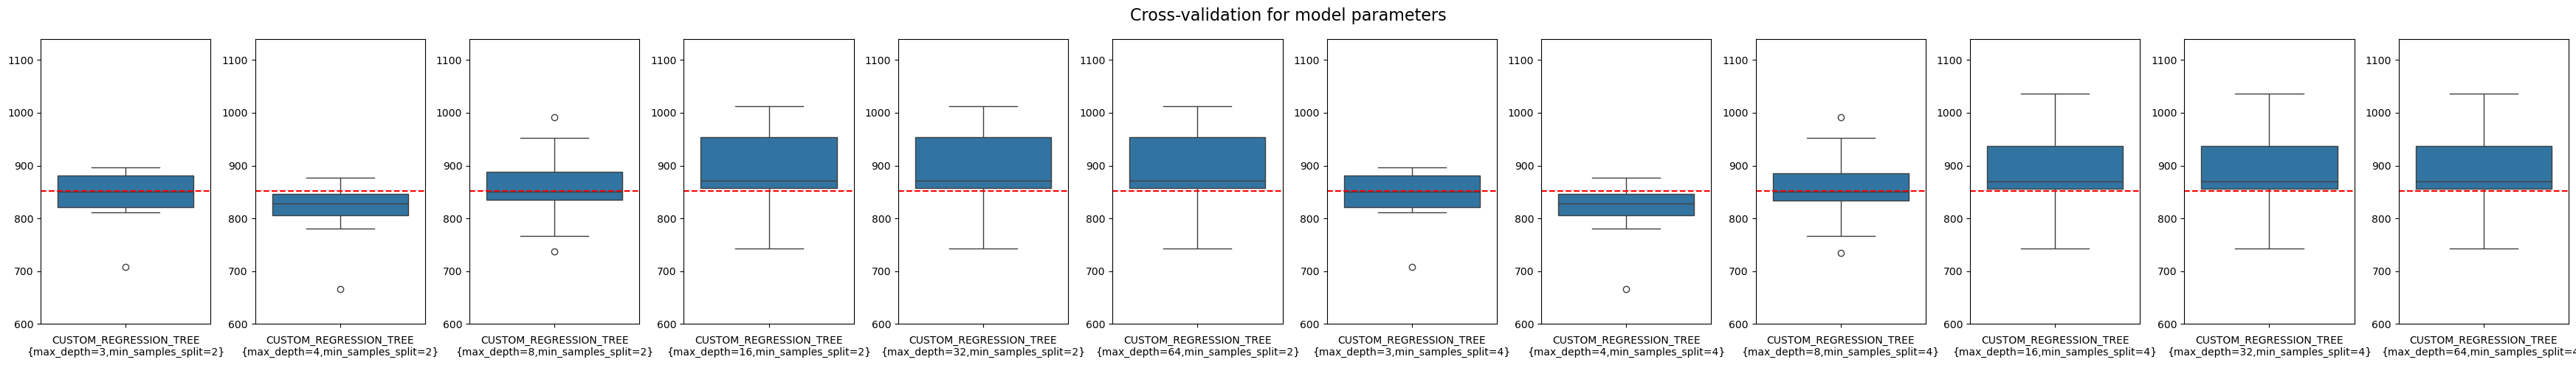

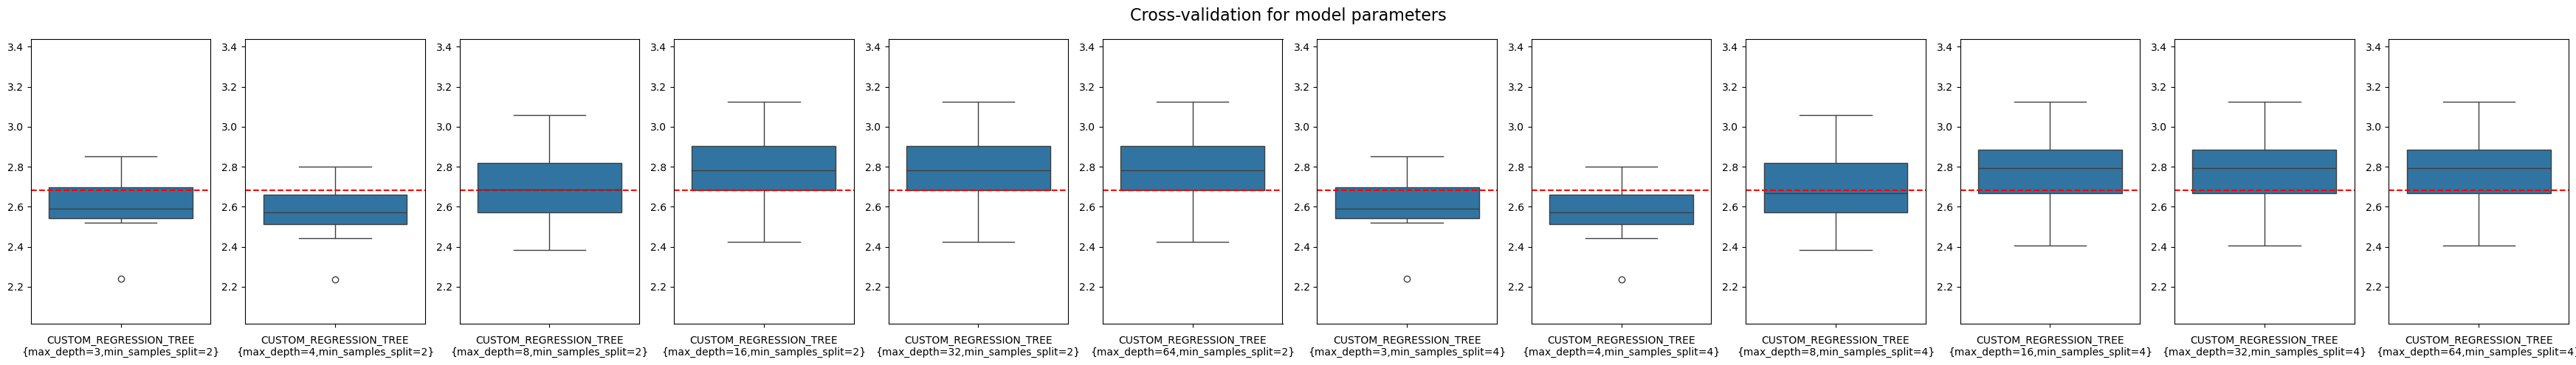

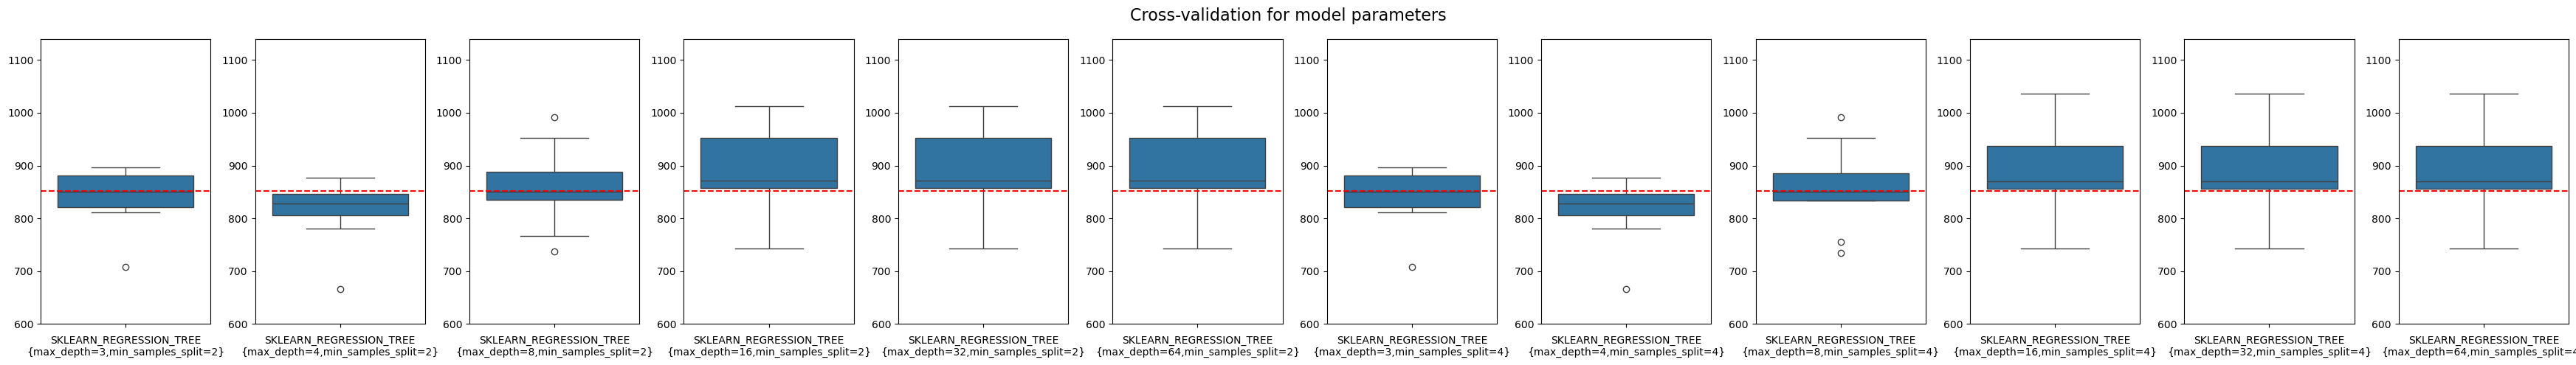

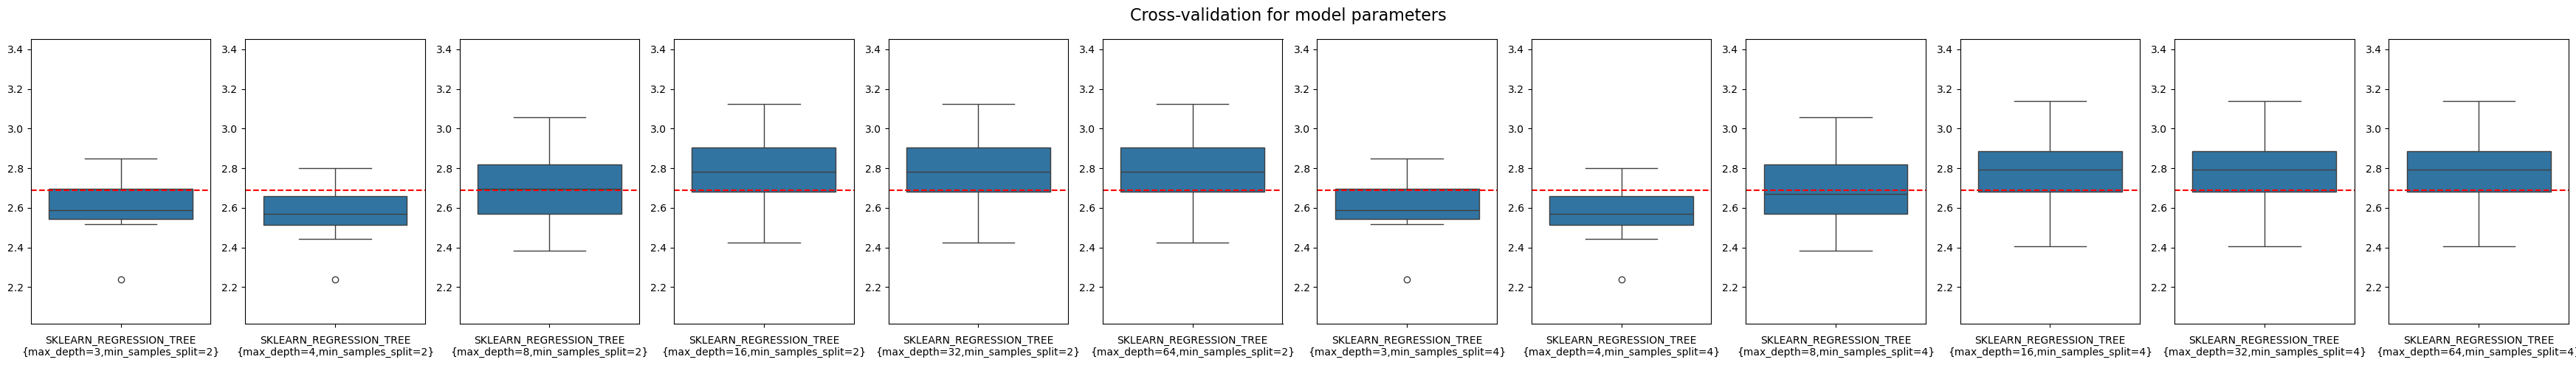

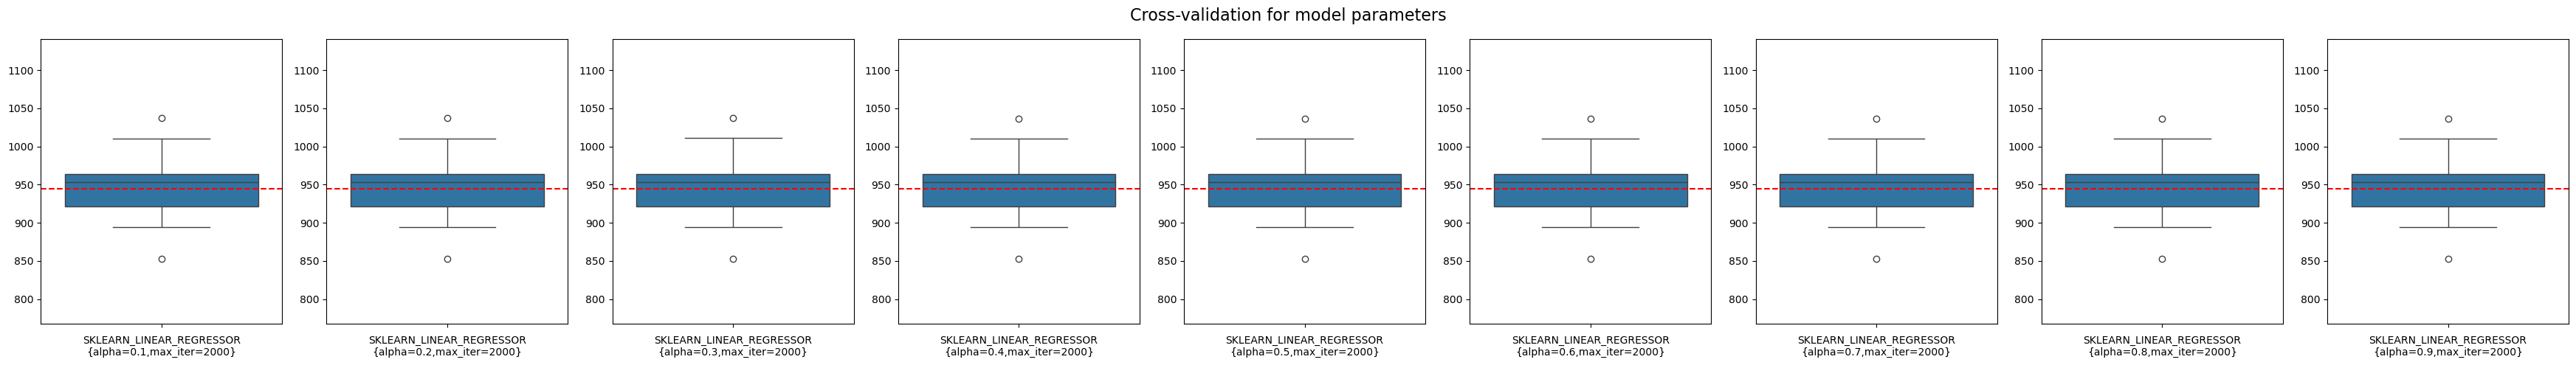

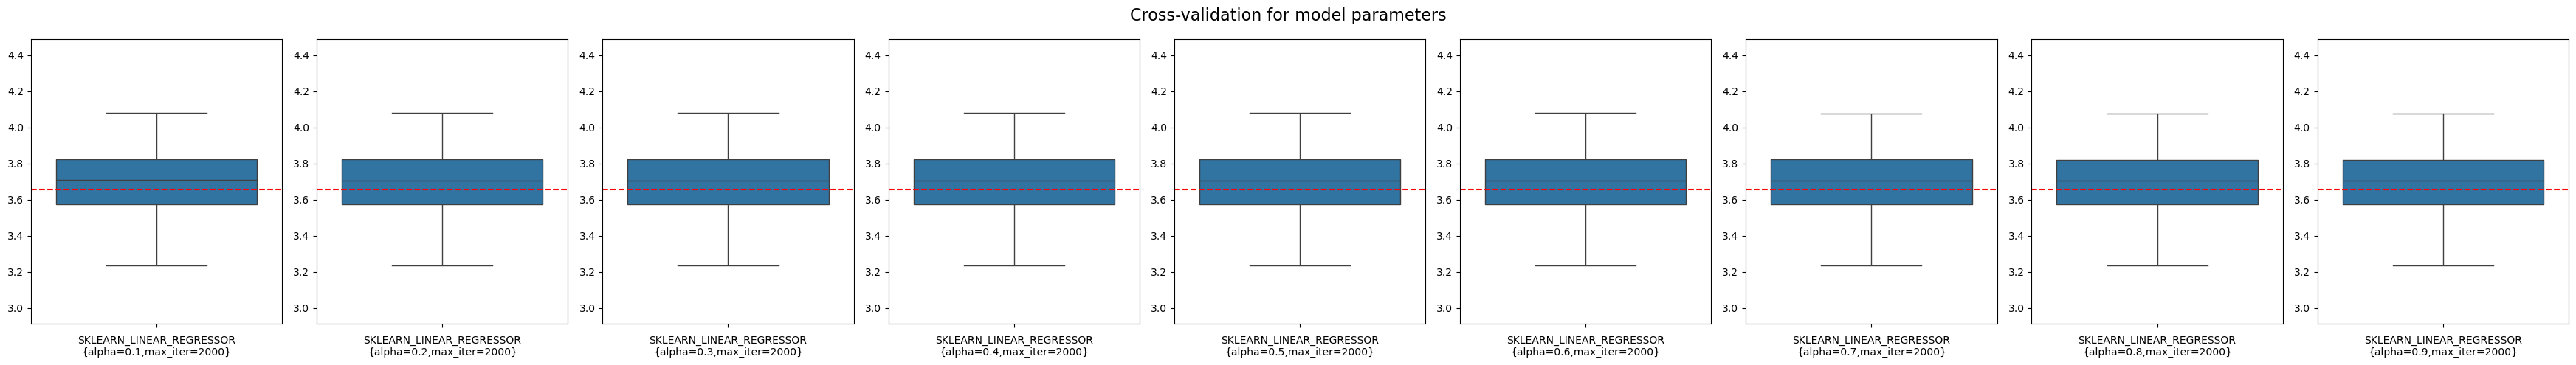

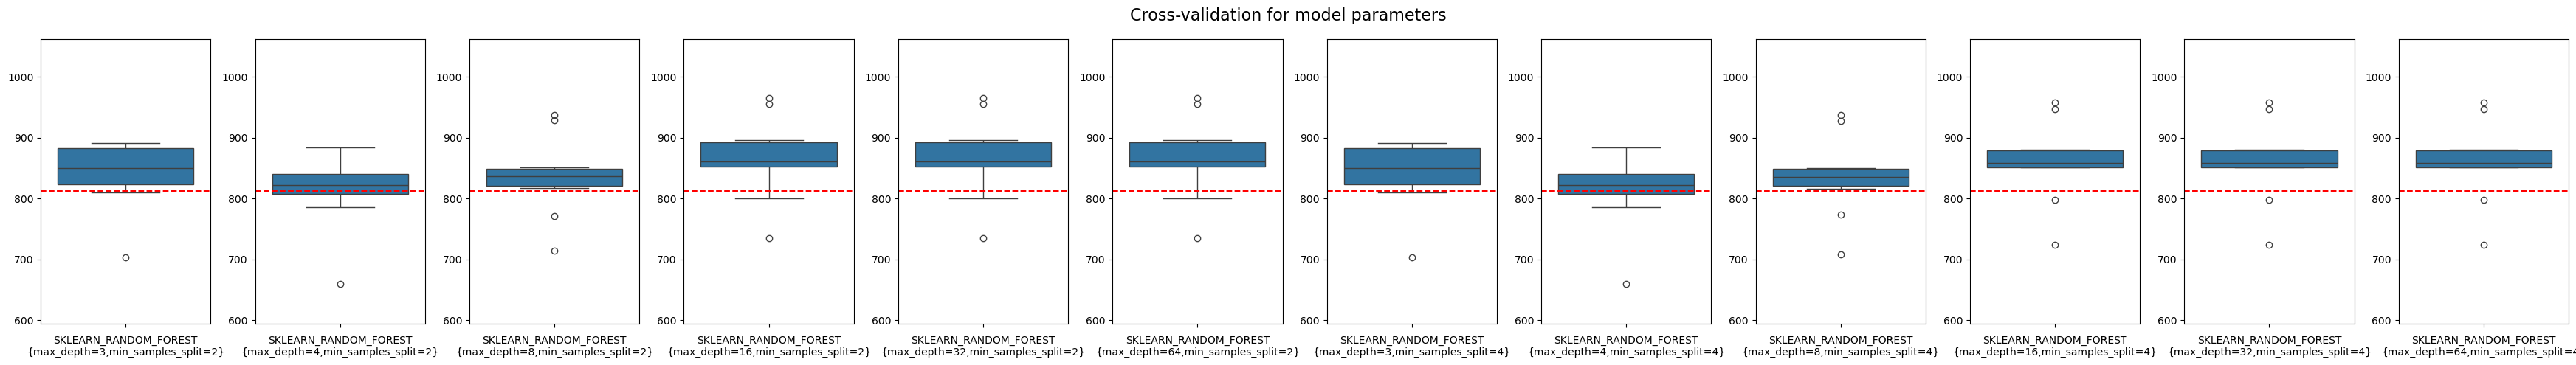

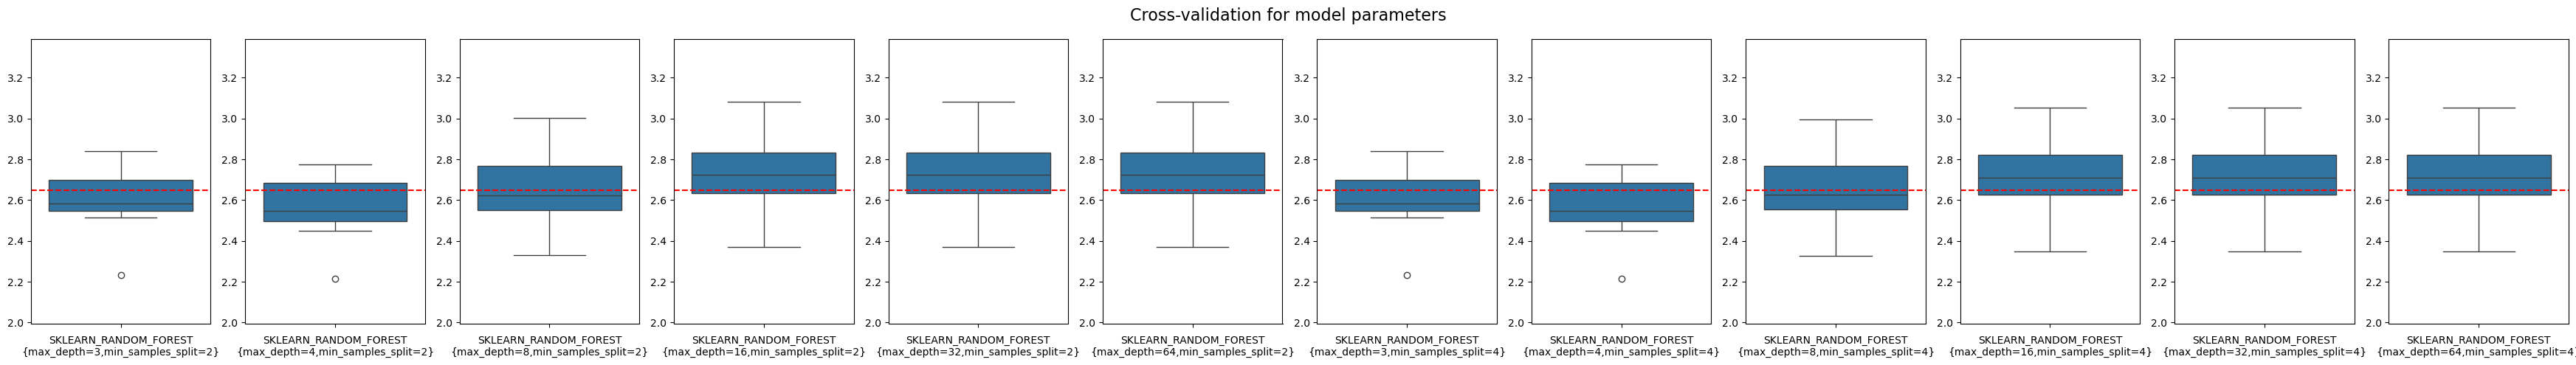

In [261]:
# summary_rmse_dfs = []
# summary_mape_dfs = []

# for model_type in unique_model_types:
#     model_scores_model_type = {k: v for k,v in model_scores.items() if model_type in k}
#     summary_rmse = generate_cv_summary(model_scores=model_scores_model_type, metric="RMSE")
#     summary_mape = generate_cv_summary(model_scores=model_scores_model_type, metric="MAPE")
    
#     summary_rmse_dfs.append(summary_rmse)
#     summary_mape_dfs.append(summary_mape)

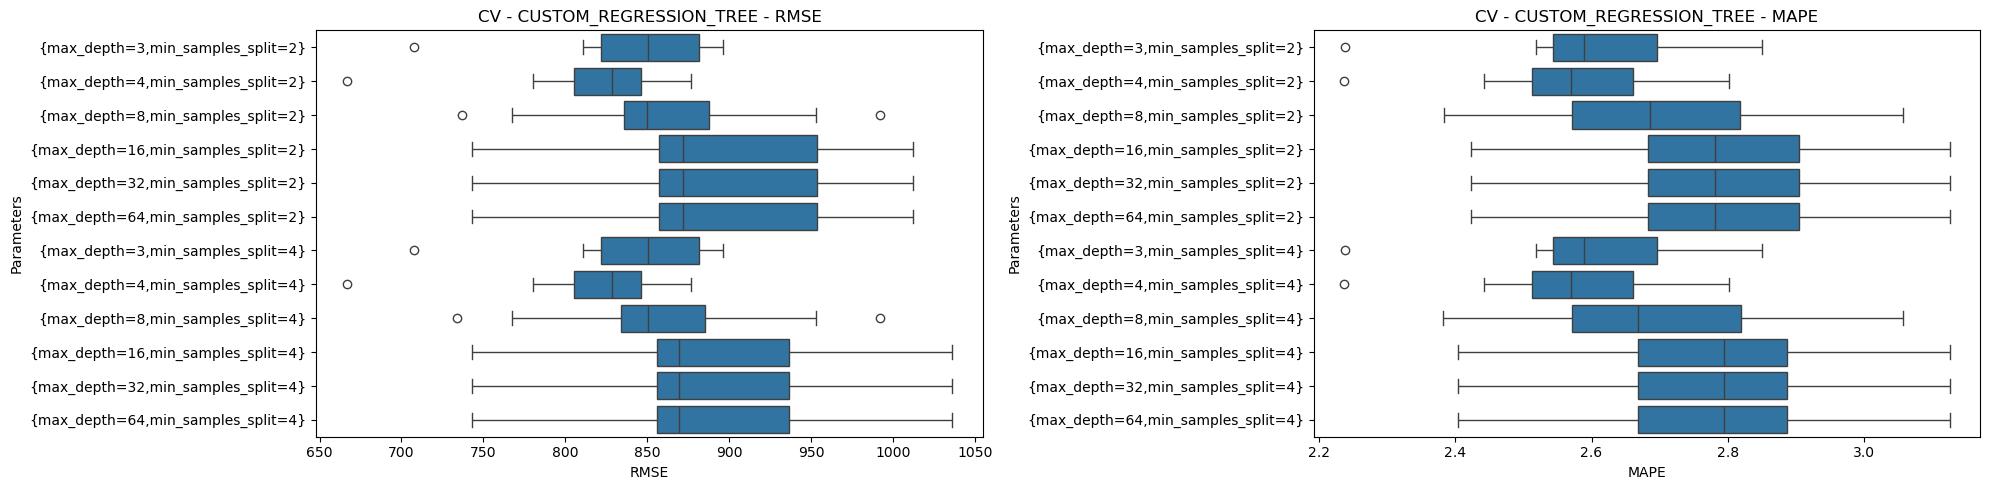

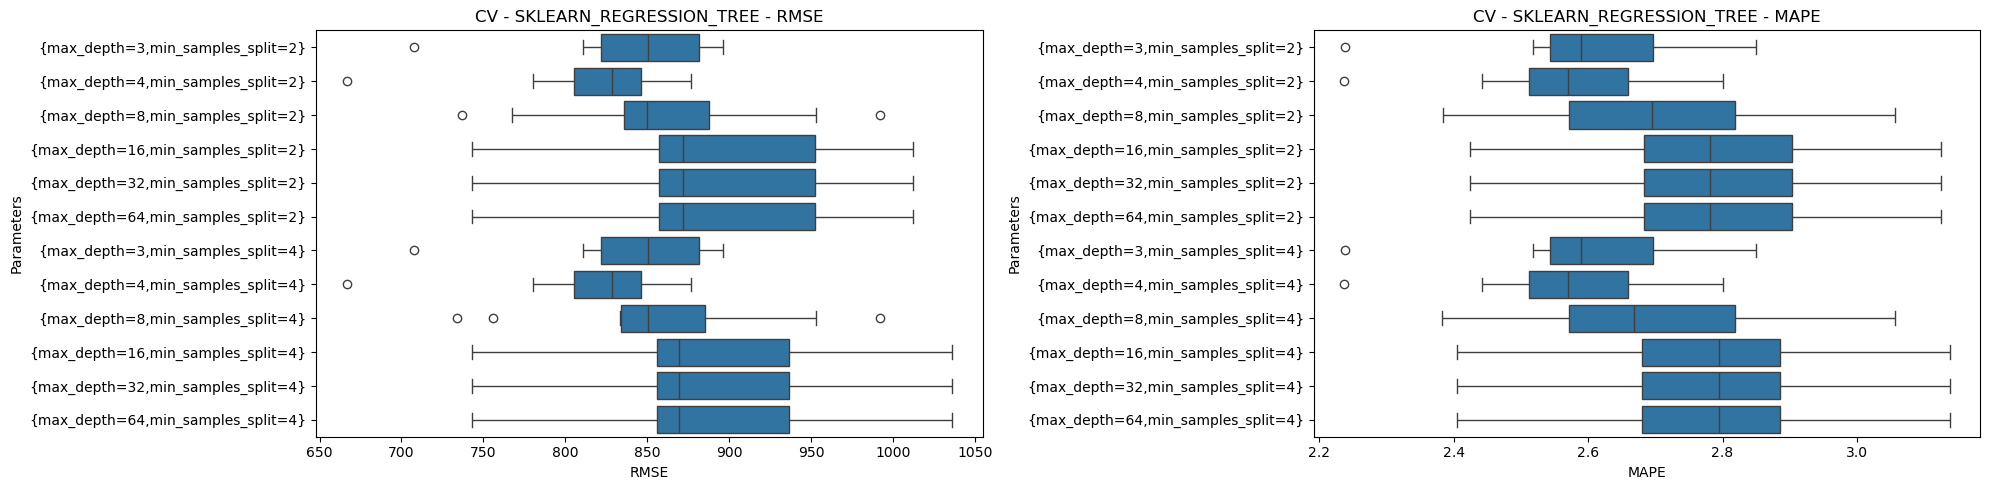

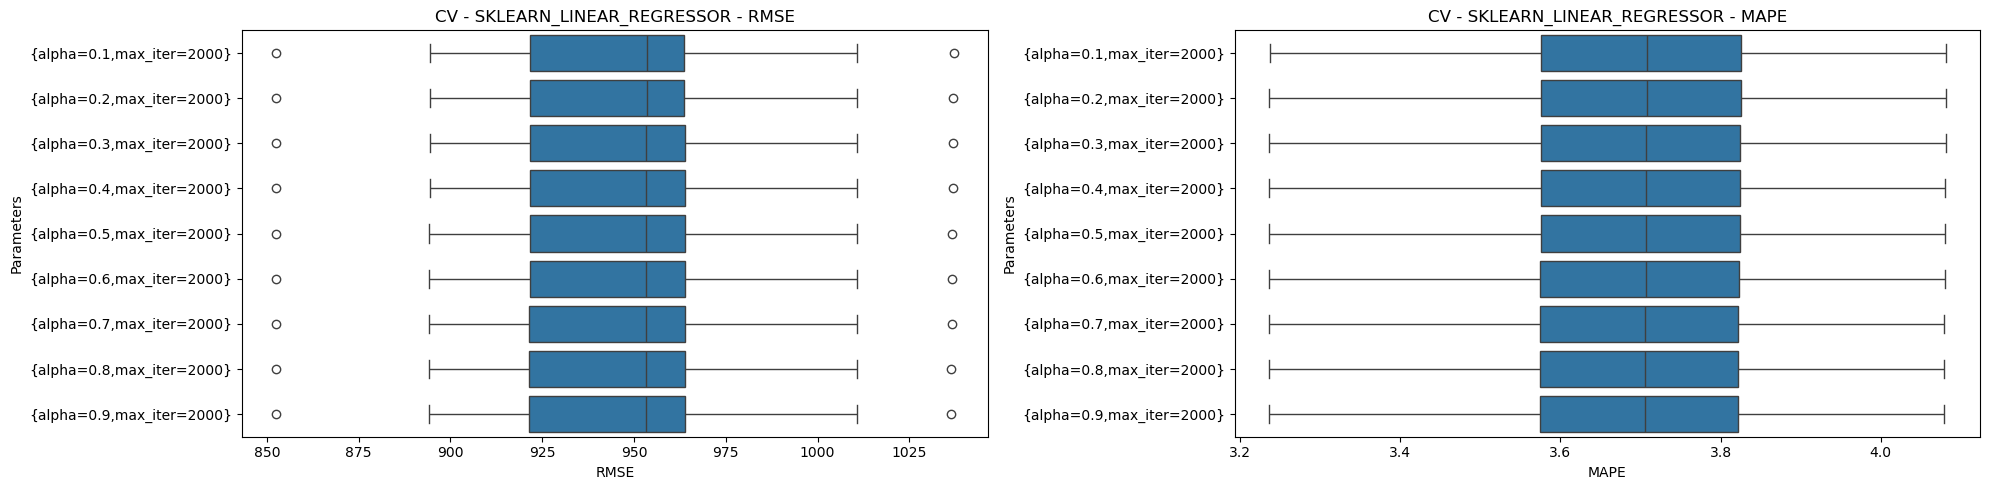

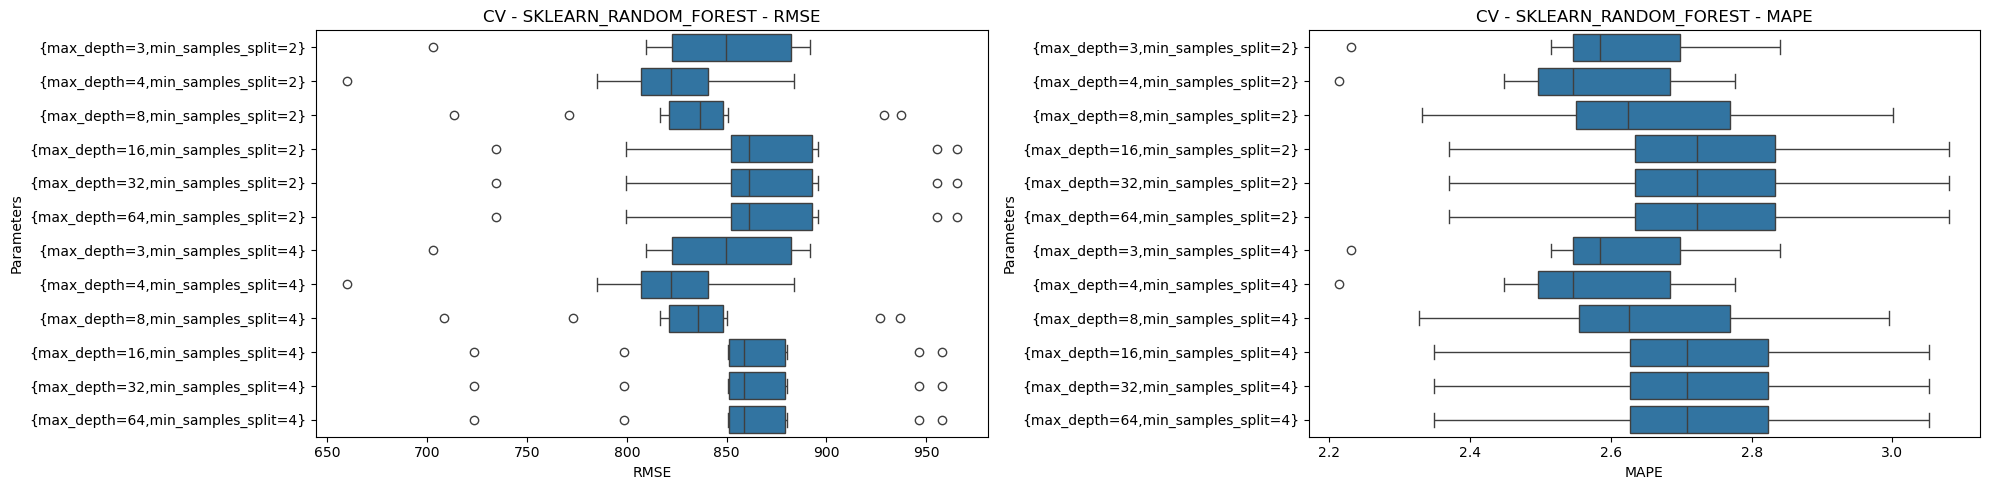

In [264]:
dfs_agg = []

for model_type in unique_model_types:
    model_scores_model_type = {k: v for k,v in model_scores.items() if model_type in k}
    dfs_model_type = []
    for k,v in model_scores_model_type.items():
        model, params = k.split("@")
        vals = v
        for metric_name, metric_vals in v.items():
            params_match = re.findall(r"([^={},\s]+)=([^={},\s]+)", params)
            df_part = pd.DataFrame([{"MODEL": model, "PARAMS": params, "METRIC": metric_name, "FOLD": fold, "VALS": m_val} for fold, m_val in enumerate(metric_vals)])
            df_part['param_dict'] = df_part['PARAMS'].apply(
                                                lambda s: dict(re.findall(r"([^={},\s]+)=([^={},\s]+)", s))
                                            )
            df_part = df_part.join(df_part['param_dict'].apply(pd.Series))
            df_part = df_part.drop("param_dict", axis=1)
            dfs_model_type.append(df_part)
            
    df_detail = pd.concat(dfs_model_type)
    df_detail

    if "max_depth" in df_detail.columns:
        df_detail["max_depth"] = df_detail["max_depth"].astype(int)
    if "min_samples_split" in df_detail.columns:
        df_detail["min_samples_split"] = df_detail["min_samples_split"].astype(int)
    if "alpha" in df_detail.columns:
        df_detail["alpha"] = df_detail["alpha"].astype(float)
    df_detail
    
    # plt.figure()
    # sns.scatterplot(data=df_detail[df_detail["METRIC"] == "RMSE"], x="max_depth", y="min_samples_split", size="VALS")

    metrics = df_detail["METRIC"].unique()
    fig, ax = plt.subplots(1,2, figsize=(20, 5))
    for i, metric in enumerate(metrics):
        df_detail_metric = df_detail[df_detail["METRIC"] == metric]
        sns.boxplot(data=df_detail_metric, x="VALS", y="PARAMS", ax=ax[i])
        ax[i].set_ylabel("Parameters")
        ax[i].set_xlabel(metric)
        ax[i].title.set_text(f"CV - {model} - {metric}")
    plt.tight_layout()

    df_detail_agg = df_detail.groupby(["MODEL", "PARAMS", "METRIC"])["VALS"].agg(["mean", "min", "max", "std"])
    dfs_agg.append(df_detail_agg)

In [265]:
df_unique_model.pivot(index=["MODEL", "PARAMS"], columns="METRIC").sort_values(("FINAL_SCORE", "RMSE"), ascending=True)

mean  \
METRIC                                                          MAPE   
MODEL                   PARAMS                                         
SKLEARN_REGRESSION_TREE {max_depth=4,min_samples_split=2}   2.565467   
                        {max_depth=4,min_samples_split=4}   2.565467   
                        {max_depth=3,min_samples_split=2}   2.595844   
                        {max_depth=3,min_samples_split=4}   2.595844   
                        {max_depth=8,min_samples_split=4}   2.697496   
                        {max_depth=8,min_samples_split=2}   2.699159   
                        {max_depth=16,min_samples_split=2}  2.791762   
                        {max_depth=32,min_samples_split=2}  2.791762   
                        {max_depth=64,min_samples_split=2}  2.791762   
                        {max_depth=16,min_samples_split=4}  2.786703   
                        {max_depth=32,min_samples_split=4}  2.786703   
                        {max_depth=64,min_samples_split=4}  2.786703   

                                                                        \
METRIC                                                            RMSE   
MODEL                   PARAMS                                           
SKLEARN_REGRESSION_TREE {max_depth=4,min_samples_split=2}   812.650706   
                        {max_depth=4,min_samples_split=4}   812.650706   
                        {max_depth=3,min_samples_split=2}   841.310011   
                        {max_depth=3,min_samples_split=4}   841.310011   
                        {max_depth=8,min_samples_split=4}   858.421224   
                        {max_depth=8,min_samples_split=2}   857.604811   
                        {max_depth=16,min_samples_split=2}  885.498633   
                        {max_depth=32,min_samples_split=2}  885.498633   
                        {max_depth=64,min_samples_split=2}  885.498633   
                        {max_depth=16,min_samples_split=4}  888.400792   
                        {max_depth=32,min_samples_split=4}  888.400792   
                        {max_depth=64,min_samples_split=4}  888.400792   

                                                                 min  \
METRIC                                                          MAPE   
MODEL                   PARAMS                                         
SKLEARN_REGRESSION_TREE {max_depth=4,min_samples_split=2}   2.236840   
                        {max_depth=4,min_samples_split=4}   2.236840   
                        {max_depth=3,min_samples_split=2}   2.238751   
                        {max_depth=3,min_samples_split=4}   2.238751   
                        {max_depth=8,min_samples_split=4}   2.363349   
                        {max_depth=8,min_samples_split=2}   2.363349   
                        {max_depth=16,min_samples_split=2}  2.421675   
                        {max_depth=32,min_samples_split=2}  2.421675   
                        {max_depth=64,min_samples_split=2}  2.421675   
                        {max_depth=16,min_samples_split=4}  2.399996   
                        {max_depth=32,min_samples_split=4}  2.399996   
                        {max_depth=64,min_samples_split=4}  2.399996   

                                                                        \
METRIC                                                            RMSE   
MODEL                   PARAMS                                           
SKLEARN_REGRESSION_TREE {max_depth=4,min_samples_split=2}   666.422410   
                        {max_depth=4,min_samples_split=4}   666.422410   
                        {max_depth=3,min_samples_split=2}   707.704956   
                        {max_depth=3,min_samples_split=4}   707.704956   
                        {max_depth=8,min_samples_split=4}   715.101594   
                        {max_depth=8,min_samples_split=2}   715.101594   
                        {max_depth=16,min_samples_split=2}  743.202155   
                        {max_depth=32,min_samples_s

Best params per model:
- Custom Regression Tree: {max_depth=4,min_samples_split=2}
- Regression Tree (SKLEARN): {max_depth=4,min_samples_split=2}
- Custom Random Forest: **PENDING**
- Random Forest (SKLEARN): {max_depth=4,min_samples_split=2}
- Lasso Regression (SKLEARN): {alpha=0.7,max_iter=2000}

In [241]:
for model in df_agg_final["MODEL"].unique():
    df_unique_model = df_agg_final[(df_agg_final["MODEL"] == model)].sort_values(by="FINAL_SCORE")
    
    display(df_unique_model.pivot(index=["MODEL", "PARAMS"], columns="METRIC").sort_values(("FINAL_SCORE", "RMSE"), ascending=True))    

mean  \
METRIC                                                         MAPE   
MODEL                  PARAMS                                         
CUSTOM_REGRESSION_TREE {max_depth=4,min_samples_split=2}   2.566350   
                       {max_depth=4,min_samples_split=4}   2.566350   
                       {max_depth=3,min_samples_split=2}   2.595844   
                       {max_depth=3,min_samples_split=4}   2.595844   
                       {max_depth=8,min_samples_split=4}   2.696390   
                       {max_depth=8,min_samples_split=2}   2.700187   
                       {max_depth=16,min_samples_split=2}  2.793744   
                       {max_depth=32,min_samples_split=2}  2.793744   
                       {max_depth=64,min_samples_split=2}  2.793744   
                       {max_depth=16,min_samples_split=4}  2.785485   
                       {max_depth=32,min_samples_split=4}  2.785485   
                       {max_depth=64,min_samples_split=4}  2.785485   

                                                                       \
METRIC                                                           RMSE   
MODEL                  PARAMS                                           
CUSTOM_REGRESSION_TREE {max_depth=4,min_samples_split=2}   812.944487   
                       {max_depth=4,min_samples_split=4}   812.944487   
                       {max_depth=3,min_samples_split=2}   841.310011   
                       {max_depth=3,min_samples_split=4}   841.310011   
                       {max_depth=8,min_samples_split=4}   857.944016   
                       {max_depth=8,min_samples_split=2}   858.729514   
                       {max_depth=16,min_samples_split=2}  888.517353   
                       {max_depth=32,min_samples_split=2}  888.517353   
                       {max_depth=64,min_samples_split=2}  888.517353   
                       {max_depth=16,min_samples_split=4}  888.401439   
                       {max_depth=32,min_samples_split=4}  888.401439   
                       {max_depth=64,min_samples_split=4}  888.401439   

                                                                min  \
METRIC                                                         MAPE   
MODEL                  PARAMS                                         
CUSTOM_REGRESSION_TREE {max_depth=4,min_samples_split=2}   2.236840   
                       {max_depth=4,min_samples_split=4}   2.236840   
                       {max_depth=3,min_samples_split=2}   2.238751   
                       {max_depth=3,min_samples_split=4}   2.238751   
                       {max_depth=8,min_samples_split=4}   2.363349   
                       {max_depth=8,min_samples_split=2}   2.363349   
                       {max_depth=16,min_samples_split=2}  2.423666   
                       {max_depth=32,min_samples_split=2}  2.423666   
                       {max_depth=64,min_samples_split=2}  2.423666   
                       {max_depth=16,min_samples_split=4}  2.401987   
                       {max_depth=32,min_samples_split=4}  2.401987   
                       {max_depth=64,min_samples_split=4}  2.401987   

                                                                       \
METRIC                                                           RMSE   
MODEL                  PARAMS                                           
CUSTOM_REGRESSION_TREE {max_depth=4,min_samples_split=2}   666.422410   
                       {max_depth=4,min_samples_split=4}   666.422410   
                       {max_depth=3,min_samples_split=2}   707.704956   
                       {max_depth=3,min_samples_split=4}   707.704956   
                       {max_depth=8,min_samples_split=4}   715.101594   
                       {max_depth=8,min_samples_split=2}   715.101594   
                       {max_depth=16,min_samples_split=2}  743.262360   
                       {max_depth=32,min_samples_split=2}  743.262360   
                       {max_dept

mean              \
METRIC                                                  MAPE        RMSE   
MODEL                    PARAMS                                            
SKLEARN_LINEAR_REGRESSOR {alpha=0.7,max_iter=2000}  3.699669  939.331565   
                         {alpha=0.6,max_iter=2000}  3.700552  939.289146   
                         {alpha=0.8,max_iter=2000}  3.698851  939.384626   
                         {alpha=0.5,max_iter=2000}  3.701456  939.256105   
                         {alpha=0.9,max_iter=2000}  3.698084  939.445623   
                         {alpha=0.4,max_iter=2000}  3.702451  939.233274   
                         {alpha=0.3,max_iter=2000}  3.703440  939.210411   
                         {alpha=0.2,max_iter=2000}  3.704606  939.212095   
                         {alpha=0.1,max_iter=2000}  3.705560  939.222426   

                                                         min              \
METRIC                                                  MAPE        RMSE   
MODEL                    PARAMS                                            
SKLEARN_LINEAR_REGRESSOR {alpha=0.7,max_iter=2000}  3.130296  832.960274   
                         {alpha=0.6,max_iter=2000}  3.127912  832.583832   
                         {alpha=0.8,max_iter=2000}  3.132764  833.344002   
                         {alpha=0.5,max_iter=2000}  3.125639  832.225638   
                         {alpha=0.9,max_iter=2000}  3.135251  833.734061   
                         {alpha=0.4,max_iter=2000}  3.123257  831.864242   
                         {alpha=0.3,max_iter=2000}  3.120029  831.419538   
                         {alpha=0.2,max_iter=2000}  3.117680  831.066857   
                         {alpha=0.1,max_iter=2000}  3.115709  830.787721   

                                                         max               \
METRIC                                                  MAPE         RMSE   
MODEL                    PARAMS                                             
SKLEARN_LINEAR_REGRESSOR {alpha=0.7,max_iter=2000}  4.243438  1027.785673   
                         {alpha=0.6,max_iter=2000}  4.248901  1027.784854   
                         {alpha=0.8,max_iter=2000}  4.237964  1027.797168   
                         {alpha=0.5,max_iter=2000}  4.254324  1027.790911   
                         {alpha=0.9,max_iter=2000}  4.232502  1027.819184   
                         {alpha=0.4,max_iter=2000}  4.260403  1027.817718   
                         {alpha=0.3,max_iter=2000}  4.266246  1027.833532   
                         {alpha=0.2,max_iter=2000}  4.271943  1027.900900   
                         {alpha=0.1,max_iter=2000}  4.277125  1027.956065   

                                                         std             \
METRIC                                                  MAPE       RMSE   
MODEL                    PARAMS                                           
SKLEARN_LINEAR_REGRESSOR {alpha=0.7,max_iter=2000}  0.286124  54.033772   
                         {alpha=0.6,max_iter=2000}  0.287726  54.080406   
                         {alpha=0.8,max_iter=2000}  0.284515  53.990987   
                         {alpha=0.5,max_iter=2000}  0.289307  54.122508   
                         {alpha=0.9,max_iter=2000}  0.282948  53.950435   
                         {alpha=0.4,max_iter=2000}  0.291064  54.174058   
                         {alpha=0.3,max_iter=2000}  0.292942  54.235549   
                         {alpha=0.2,max_iter=2000}  0.294594  54.293815   
                         {alpha=0.1,max_iter=2000}  0.296153  54.332588   

                                                   FINAL_SCORE              
METRIC                                                    MAPE        RMSE  
MODEL                    PARAMS                                             
SKLEARN_LINEAR_REGRESSOR {alpha=0.7,max_iter=2000}    3.985793  993.365337  
                         {alpha=0.6,max_iter=2000}    3.988277  993.369552  
                   

mean  \
METRIC                                                        MAPE   
MODEL                 PARAMS                                         
SKLEARN_RANDOM_FOREST {max_depth=4,min_samples_split=2}   2.557311   
                      {max_depth=4,min_samples_split=4}   2.557311   
                      {max_depth=3,min_samples_split=2}   2.593869   
                      {max_depth=3,min_samples_split=4}   2.593869   
                      {max_depth=8,min_samples_split=4}   2.656305   
                      {max_depth=8,min_samples_split=2}   2.658470   
                      {max_depth=16,min_samples_split=4}  2.721865   
                      {max_depth=32,min_samples_split=4}  2.721865   
                      {max_depth=64,min_samples_split=4}  2.721865   
                      {max_depth=16,min_samples_split=2}  2.738555   
                      {max_depth=32,min_samples_split=2}  2.738555   
                      {max_depth=64,min_samples_split=2}  2.738555   

                                                                      \
METRIC                                                          RMSE   
MODEL                 PARAMS                                           
SKLEARN_RANDOM_FOREST {max_depth=4,min_samples_split=2}   811.038976   
                      {max_depth=4,min_samples_split=4}   811.038976   
                      {max_depth=3,min_samples_split=2}   840.318746   
                      {max_depth=3,min_samples_split=4}   840.318746   
                      {max_depth=8,min_samples_split=4}   835.425190   
                      {max_depth=8,min_samples_split=2}   836.576353   
                      {max_depth=16,min_samples_split=4}  860.351813   
                      {max_depth=32,min_samples_split=4}  860.351813   
                      {max_depth=64,min_samples_split=4}  860.351813   
                      {max_depth=16,min_samples_split=2}  865.963402   
                      {max_depth=32,min_samples_split=2}  865.963402   
                      {max_depth=64,min_samples_split=2}  865.963402   

                                                               min  \
METRIC                                                        MAPE   
MODEL                 PARAMS                                         
SKLEARN_RANDOM_FOREST {max_depth=4,min_samples_split=2}   2.213636   
                      {max_depth=4,min_samples_split=4}   2.213636   
                      {max_depth=3,min_samples_split=2}   2.231298   
                      {max_depth=3,min_samples_split=4}   2.231298   
                      {max_depth=8,min_samples_split=4}   2.320370   
                      {max_depth=8,min_samples_split=2}   2.327119   
                      {max_depth=16,min_samples_split=4}  2.349428   
                      {max_depth=32,min_samples_split=4}  2.349428   
                      {max_depth=64,min_samples_split=4}  2.349428   
                      {max_depth=16,min_samples_split=2}  2.370830   
                      {max_depth=32,min_samples_split=2}  2.370830   
                      {max_depth=64,min_samples_split=2}  2.370830   

                                                                      \
METRIC                                                          RMSE   
MODEL                 PARAMS                                           
SKLEARN_RANDOM_FOREST {max_depth=4,min_samples_split=2}   659.255554   
                      {max_depth=4,min_samples_split=4}   659.255554   
                      {max_depth=3,min_samples_split=2}   703.062571   
                      {max_depth=3,min_samples_split=4}   703.062571   
                      {max_depth=8,min_samples_split=4}   703.268714   
                      {max_depth=8,min_samples_split=2}   709.523085   
                      {max_depth=16,min_samples_split=4}  721.511100   
                      {max_depth=32,min_samples_split=4}  721.511100   
                      {max_depth=64,min_samples_split=4}  721.511100   
               

mean  \
METRIC                                                          MAPE   
MODEL                   PARAMS                                         
SKLEARN_REGRESSION_TREE {max_depth=4,min_samples_split=2}   2.565467   
                        {max_depth=4,min_samples_split=4}   2.565467   
                        {max_depth=3,min_samples_split=2}   2.595844   
                        {max_depth=3,min_samples_split=4}   2.595844   
                        {max_depth=8,min_samples_split=4}   2.697496   
                        {max_depth=8,min_samples_split=2}   2.699159   
                        {max_depth=16,min_samples_split=2}  2.791762   
                        {max_depth=32,min_samples_split=2}  2.791762   
                        {max_depth=64,min_samples_split=2}  2.791762   
                        {max_depth=16,min_samples_split=4}  2.786703   
                        {max_depth=32,min_samples_split=4}  2.786703   
                        {max_depth=64,min_samples_split=4}  2.786703   

                                                                        \
METRIC                                                            RMSE   
MODEL                   PARAMS                                           
SKLEARN_REGRESSION_TREE {max_depth=4,min_samples_split=2}   812.650706   
                        {max_depth=4,min_samples_split=4}   812.650706   
                        {max_depth=3,min_samples_split=2}   841.310011   
                        {max_depth=3,min_samples_split=4}   841.310011   
                        {max_depth=8,min_samples_split=4}   858.421224   
                        {max_depth=8,min_samples_split=2}   857.604811   
                        {max_depth=16,min_samples_split=2}  885.498633   
                        {max_depth=32,min_samples_split=2}  885.498633   
                        {max_depth=64,min_samples_split=2}  885.498633   
                        {max_depth=16,min_samples_split=4}  888.400792   
                        {max_depth=32,min_samples_split=4}  888.400792   
                        {max_depth=64,min_samples_split=4}  888.400792   

                                                                 min  \
METRIC                                                          MAPE   
MODEL                   PARAMS                                         
SKLEARN_REGRESSION_TREE {max_depth=4,min_samples_split=2}   2.236840   
                        {max_depth=4,min_samples_split=4}   2.236840   
                        {max_depth=3,min_samples_split=2}   2.238751   
                        {max_depth=3,min_samples_split=4}   2.238751   
                        {max_depth=8,min_samples_split=4}   2.363349   
                        {max_depth=8,min_samples_split=2}   2.363349   
                        {max_depth=16,min_samples_split=2}  2.421675   
                        {max_depth=32,min_samples_split=2}  2.421675   
                        {max_depth=64,min_samples_split=2}  2.421675   
                        {max_depth=16,min_samples_split=4}  2.399996   
                        {max_depth=32,min_samples_split=4}  2.399996   
                        {max_depth=64,min_samples_split=4}  2.399996   

                                                                        \
METRIC                                                            RMSE   
MODEL                   PARAMS                                           
SKLEARN_REGRESSION_TREE {max_depth=4,min_samples_split=2}   666.422410   
                        {max_depth=4,min_samples_split=4}   666.422410   
                        {max_depth=3,min_samples_split=2}   707.704956   
                        {max_depth=3,min_samples_split=4}   707.704956   
                        {max_depth=8,min_samples_split=4}   715.101594   
                        {max_depth=8,min_samples_split=2}   715.101594   
                        {max_depth=16,min_samples_split=2}  743.202155   
                        {max_depth=32,min_samples_s

In [242]:
# df_agg_final = pd.concat(dfs_agg).reset_index()
# df_agg_final

# df_agg_final["FINAL_SCORE"] = df_agg_final["mean"] + df_agg_final["std"]
# df_agg_final

# df_agg_final = df_agg_final.sort_values(by=["MODEL", "FINAL_SCORE"])

# for model in df_agg_final["MODEL"].unique():
#     df_unique_model = df_agg_final[(df_agg_final["MODEL"] == model) & (df_agg_final["METRIC"] == "RMSE")]
#     plt.figure()
#     sns.barplot(data=df_unique_model, y="PARAMS", x="FINAL_SCORE", hue="METRIC")

In [252]:
X_test

array([[ 0.        ,  0.        ,  0.        , ..., -0.34015897,
        -1.53672029,  0.18100838],
       [ 0.        ,  0.        ,  1.        , ..., -1.19215681,
         0.05394574, -0.11233189],
       [ 0.        ,  0.        ,  0.        , ..., -0.34015897,
         1.00834536,  0.18100838],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -0.62415825,
        -0.90045388,  0.47434865],
       [ 0.        ,  1.        ,  0.        , ...,  0.79583815,
         0.37207895, -0.11233189],
       [ 0.        ,  0.        ,  0.        , ..., -0.62415825,
        -0.90045388, -1.7257034 ]], shape=(837, 71))

In [266]:
feat_cols = [col for col in df_train if col != LABEL_COL]

numeric_features = df_train[feat_cols].select_dtypes(include=["number"]).columns.tolist()
categorical_features = [c for c in feat_cols if c not in numeric_features]

X_train_raw = df_train[feat_cols]
X_test_raw = df_test[feat_cols]

y_train = df_train[LABEL_COL].values
y_test = df_test[LABEL_COL].values

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
        ("num", StandardScaler(), numeric_features),
    ]
)

# Fit on train fold, transform both train and test
X_train = preprocessor.fit_transform(X_train_raw)
X_test = preprocessor.transform(X_test_raw)

# Custom Regression Tree
params = {"max_depth":4,"min_samples_split":2}
model = "CUSTOM_REGRESSION_TREE"
model_name = create_model_name(model=model, params=params)
custom_reg_tree_model = CustomRegressionTree(**params)
custom_reg_tree_model.fit(X_train, y_train)
custom_reg_tree_preds = custom_reg_tree_model.predict(X_test)
custom_reg_tree_metrics = get_scores(reals=y_test, preds=custom_reg_tree_preds)
print(custom_reg_tree_metrics)

# SKLearn Regression Tree
params = {"max_depth":4, "min_samples_split":2}
model = "SKLEARN_REGRESSION_TREE"
model_name = create_model_name(model=model, params=params)
tree_regressor = DecisionTreeRegressor(**params, random_state=RANDOM_STATE)
tree_regressor.fit(X_train, y_train)
tree_regressor_preds = tree_regressor.predict(X_test)
reg_tree_metrics = get_scores(reals=y_test, preds=tree_regressor_preds)
print(reg_tree_metrics)

# SKLearn Random Forest
model = "SKLEARN_RANDOM_FOREST"
params = {"max_depth":4, "min_samples_split":2}
model_name = create_model_name(model=model, params=params)
rand_forest_regr = RandomForestRegressor(**params, random_state=RANDOM_STATE)
rand_forest_regr.fit(X_train, y_train)
rand_forest_preds = rand_forest_regr.predict(X_test)
rand_forest_metrics = get_scores(reals=y_test, preds=rand_forest_preds)
print(rand_forest_metrics)

# SKLearn Lasso Regression
model = "SKLEARN_LINEAR_REGRESSOR"
params = {"alpha":0.7, "max_iter":2000}
model_name = create_model_name(model=model, params=params)
lasso_regr = linear_model.Lasso(**params, random_state=RANDOM_STATE)
lasso_regr.fit(X_train, y_train)
lasso_preds = lasso_regr.predict(X_test)
lasso_metrics = get_scores(reals=y_test, preds=lasso_preds)
print(lasso_metrics)

{'RMSE': np.float64(806.2210908495672), 'MAPE': np.float64(2.5753240394450128)}
{'RMSE': np.float64(806.2210908495672), 'MAPE': np.float64(2.5753240394450128)}
{'RMSE': np.float64(805.5691316154031), 'MAPE': np.float64(2.5622577762708514)}
{'RMSE': np.float64(945.0580956515342), 'MAPE': np.float64(3.5731685973847016)}


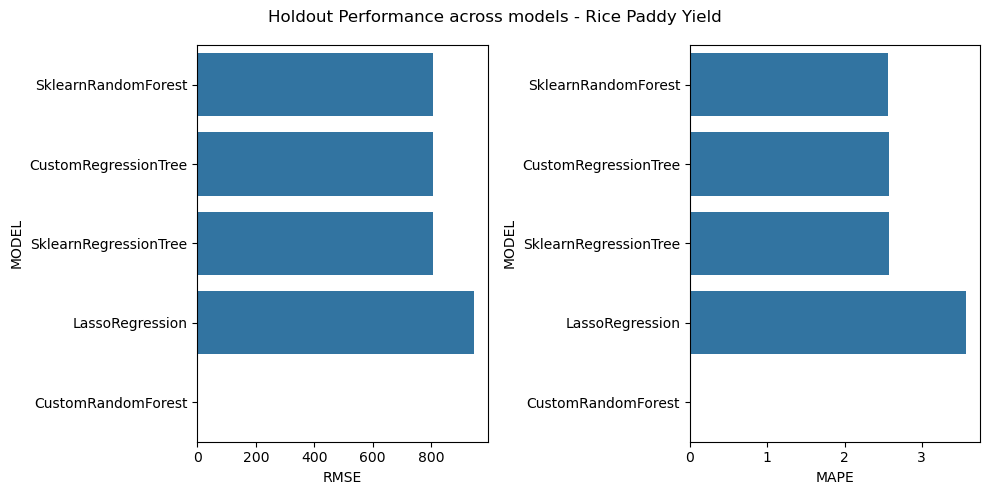

In [279]:
df_report = pd.DataFrame([
    {"MODEL": "CustomRegressionTree", "RMSE": custom_reg_tree_metrics["RMSE"], "MAPE": custom_reg_tree_metrics["MAPE"]},
    {"MODEL": "SklearnRegressionTree", "RMSE": reg_tree_metrics["RMSE"], "MAPE": reg_tree_metrics["MAPE"]},
    {"MODEL": "CustomRandomForest", "RMSE": None, "MAPE": None},
    {"MODEL": "SklearnRandomForest", "RMSE": rand_forest_metrics["RMSE"], "MAPE": rand_forest_metrics["MAPE"]},
    {"MODEL": "LassoRegression", "RMSE": lasso_metrics["RMSE"], "MAPE": lasso_metrics["MAPE"]},
])
df_report = df_report.sort_values(by="RMSE")

fig, ax = plt.subplots(1, 2, figsize=(10,5))
sns.barplot(data=df_report, y="MODEL", x="RMSE", ax=ax[0])
sns.barplot(data=df_report, y="MODEL", x="MAPE", ax=ax[1])
plt.suptitle("Holdout Performance across models - Rice Paddy Yield");
plt.tight_layout()